## Observe distributions, counts, and metadata

In [1]:
import pathlib
import numpy as np
import pandas as pd

import plotnine as gg
import seaborn as sns

In [2]:
# Load data
gene_file = pathlib.Path("data/annotated_highMAS_lowTAS_genes.tsv")

gene_df = pd.read_csv(gene_file, sep="\t").drop_duplicates(["cpd", "moa", "landmark_genes" "gene_symbol"])

print(gene_df.shape)
gene_df.head()

(4232, 7)


,cpd,dose,landmark_genes,moa,MAS,TAS,gene_symbol
0,17-hydroxyprogesterone-caproate,6,205039_s_at,Progesterone receptor agonist,0.709677,0.18512,IKZF1
1,17-hydroxyprogesterone-caproate,6,207515_s_at,Progesterone receptor agonist,0.709677,0.18512,POLR1C
2,17-hydroxyprogesterone-caproate,6,208763_s_at,Progesterone receptor agonist,0.709677,0.18512,TSC22D3
3,17-hydroxyprogesterone-caproate,6,201761_at,Progesterone receptor agonist,0.709677,0.18512,MTHFD2
4,17-hydroxyprogesterone-caproate,6,201000_at,Progesterone receptor agonist,0.709677,0.18512,AARS


In [4]:
gene_count_df = (
    gene_df
    .groupby("gene_symbol")
    .agg({"MAS": "mean", "TAS": "mean"})
    .merge(
        gene_df.groupby("gene_symbol")["cpd"].count().reset_index(),
        on="gene_symbol"
    )
    .sort_values(by="cpd", ascending=False)
    .reset_index(drop=True)
    .rename({"cpd": "gene_count"}, axis="columns")
)

print(gene_count_df.shape)
gene_count_df.head()

(765, 4)


,gene_symbol,MAS,TAS,gene_count
0,CDKN1A,0.792654,0.200945,51
1,SESN1,0.785608,0.193058,43
2,CDC45,0.792349,0.240929,42
3,TSC22D3,0.759481,0.209315,42
4,HMGCS1,0.773231,0.194467,40


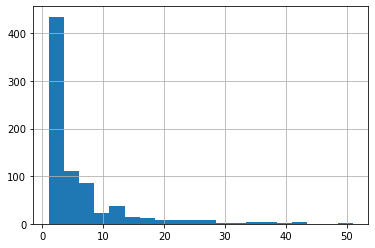

In [5]:
gene_count_df.gene_count.hist(bins=20)

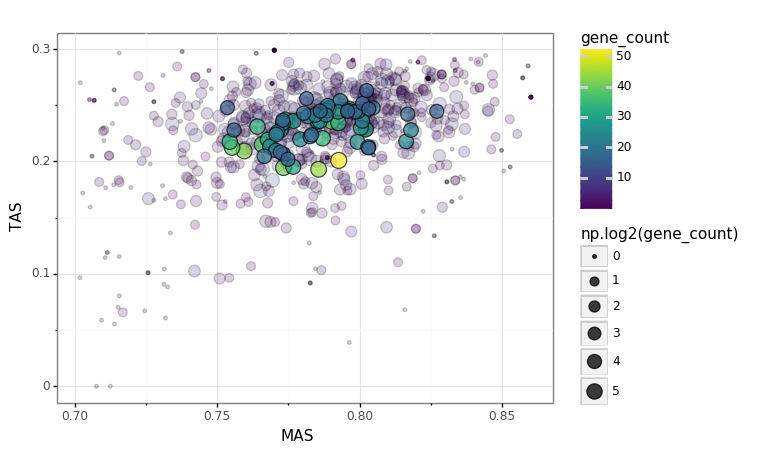

<ggplot: (406627606)>

In [36]:
(
    gg.ggplot(gg.aes(x="MAS", y="TAS"))
    + gg.geom_point(gg.aes(fill="gene_count", size="np.log2(gene_count)"), data = gene_count_df.query("gene_count < 15"), alpha=0.2)
    + gg.geom_point(gg.aes(fill="gene_count", size="np.log2(gene_count)"), data = gene_count_df.query("gene_count >= 15"), alpha=0.7)
    + gg.theme_bw()
)

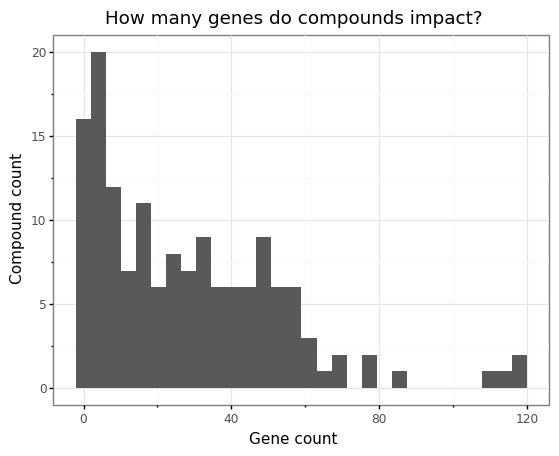

<ggplot: (403232579)>

In [52]:
compound_number_df = gene_df.cpd.value_counts().reset_index().sort_values(by="cpd", ascending=False)

(
    gg.ggplot(compound_number_df, gg.aes(x="cpd"))
    + gg.geom_histogram(bins=30)
    + gg.theme_bw()
    + gg.xlab("Gene count")
    + gg.ylab("Compound count")
    + gg.ggtitle("How many genes do compounds impact?")
)

In [54]:
compound_number_df.head(10)

,index,cpd
0,dasatinib,119
1,cabazitaxel,117
2,cladribine,114
3,alisertib,110
4,pf-03758309,85
5,sb-743921,78
6,floxuridine,78
7,podophyllotoxin,69
8,lgx818,68
9,thioguanine,66


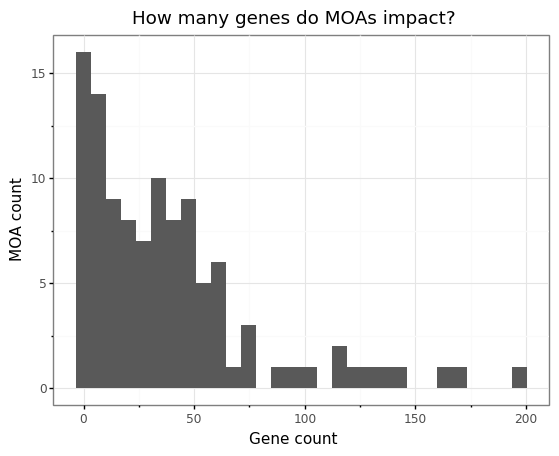

<ggplot: (405485818)>

In [56]:
moa_number_df = gene_df.moa.value_counts().reset_index().sort_values(by="moa", ascending=False)

(
    gg.ggplot(moa_number_df, gg.aes(x="moa"))
    + gg.geom_histogram(bins=30)
    + gg.theme_bw()
    + gg.xlab("Gene count")
    + gg.ylab("MOA count")
    + gg.ggtitle("How many genes do MOAs impact?")
)

In [57]:
moa_number_df.head(10)

,index,moa
0,PLK inhibitor,198
1,Microtubule inhibitor,173
2,Tubulin inhibitor,162
3,Glucocorticoid receptor agonist,146
4,Aurora kinase inhibitor,135
5,CDK inhibitor,127
6,KIT inhibitor|Src inhibitor|Bcr-Abl kinase inh...,119
7,Purine antagonist,115
8,Adenosine deaminase inhibitor|Ribonucleoside r...,114
9,Topoisomerase inhibitor,101


In [26]:
# We will visualize this with complex heatmap in R
occurence_df = (
    gene_df
    .loc[:, ["cpd", "dose", "gene_symbol"]]
    .reset_index()
    .pivot_table(values="index", columns="gene_symbol", index="cpd", aggfunc="count")
    .fillna(0)
)

cooccurence_df = (
    occurence_df.astype(int)
    .T
    .dot(occurence_df.astype(int))
)

output_file = pathlib.Path("data/gene_cooccurence_by_compound.csv")
cooccurence_df.to_csv(output_file)

cooccurence_df = cooccurence_df.rename_axis("gene_symbol_index")

print(cooccurence_df.shape)
cooccurence_df.head(10)

(765, 765)


gene_symbol,AARS,ABCB6,ABCC5,ABHD4,ABHD6,ABL1,ACAA1,ACAT2,ACBD3,ACD,...,YME1L1,YTHDF1,ZDHHC6,ZFP36,ZMYM2,ZNF274,ZNF318,ZNF586,ZNF589,ZW10
gene_symbol_index,,,,,,,,,,,,,,,,,,,,,
AARS,17,0,1,1,1,1,0,4,0,0,...,1,1,2,0,0,0,1,0,0,1
ABCB6,0,7,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ABCC5,1,0,1,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
ABHD4,1,1,0,6,0,0,0,0,0,2,...,1,1,0,0,1,1,2,0,0,0
ABHD6,1,0,0,0,4,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0
ABL1,1,0,1,0,0,2,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
ACAA1,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ACAT2,4,0,0,0,0,0,0,17,0,0,...,0,0,0,0,0,0,0,1,0,0
ACBD3,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [61]:
cooccurence_df.unstack().reset_index().rename({0: "compound_count"}, axis="columns")

,gene_symbol,gene_symbol_index,compound_count
0,AARS,AARS,17
1,AARS,ABCB6,0
2,AARS,ABCC5,1
3,AARS,ABHD4,1
4,AARS,ABHD6,1
...,...,...,...
585220,ZW10,ZNF274,0
585221,ZW10,ZNF318,0
585222,ZW10,ZNF586,0
585223,ZW10,ZNF589,0
